In [1]:
# 示例：USDA食品数据库
import json
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

%matplotlib inline

In [2]:
db = json.load(open('../data/usda_food/database.json'))
len(db)

6636

In [3]:
db[0].keys() # 查看有哪些字段

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [4]:
db[0]['nutrients'][0] # 查看第0条记录营养成分的第一个元素

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [5]:
nutrients = DataFrame(db[0]['nutrients']) # 根据第0条记录的营养成本构造一个DataFrame
nutrients.head()

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00


In [6]:
info_keys = ['description', 'group', 'id', 'manufacturer']
info = DataFrame(db, columns=info_keys) # 根据指定的列构造DataFrame
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [7]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [8]:
pd.value_counts(info.group) # 查看group这列各个值的出现次数

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Beverages                            278
Soups, Sauces, and Gravies           275
Finfish and Shellfish Products       255
Baby Foods                           209
Cereal Grains and Pasta              183
Ethnic Foods                         165
Snacks                               162
Nut and Seed Products                128
Poultry Products                     116
Sausages and Luncheon Meats          111
Dairy and Egg Products               107
Fats and Oils                         97
Meals, Entrees, and Sidedishes        57
Restaurant Foods                      51
Spices and Herbs

In [9]:
nutrients = []
# 把每条记录的营养成分单独拿出来做一个DataFrame，同时用id匹配原记录。
for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)
nutrients = pd.concat(nutrients, ignore_index=True)
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [10]:
nutrients.duplicated().sum() # 看下有多少条重复记录

14179

In [11]:
nutrients = nutrients.drop_duplicates() # 删除重复记录

In [12]:
col_mapping = {'description': 'food', 'group': 'fgroup'}
info = info.rename(columns=col_mapping, copy=False) # 列重命名
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
food            6636 non-null object
fgroup          6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [13]:
col_mapping = {'description': 'nutrient', 'group': 'nutgroup'}
nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 389354
Data columns (total 5 columns):
nutrient    375176 non-null object
nutgroup    375176 non-null object
units       375176 non-null object
value       375176 non-null float64
id          375176 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.2+ MB


In [14]:
ndata = pd.merge(nutrients, info, on='id', how='outer') # 做一个全连接
print(ndata.head())
print(ndata.info())

                      nutrient     nutgroup units   value    id  \
0                      Protein  Composition     g   25.18  1008   
1            Total lipid (fat)  Composition     g   29.20  1008   
2  Carbohydrate, by difference  Composition     g    3.06  1008   
3                          Ash        Other     g    3.28  1008   
4                       Energy       Energy  kcal  376.00  1008   

              food                  fgroup manufacturer  
0  Cheese, caraway  Dairy and Egg Products               
1  Cheese, caraway  Dairy and Egg Products               
2  Cheese, caraway  Dairy and Egg Products               
3  Cheese, caraway  Dairy and Egg Products               
4  Cheese, caraway  Dairy and Egg Products               
<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
units           375176 non-null object
value           375176

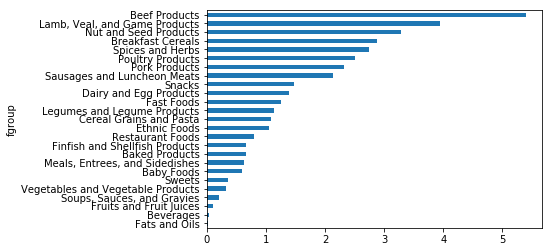

In [15]:
# 根据营养成分和食物种类分组，quantile(0.5)自动计算中位数。
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5) 
result['Zinc, Zn'].sort_values().plot(kind='barh') # 各种食物锌含量的中位数

In [16]:
get_maximum = lambda x: x.xs(x.value.idxmax()) # 根据最大值的位置选择一行
get_minimum = lambda x: x.xs(x.value.idxmin())
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']] # 每个营养种类里，对应每个营养成分，含量最高的食物。
max_foods.head()

value  \
nutgroup    nutrient                
Amino Acids Alanine         8.009   
            Arginine        7.436   
            Aspartic acid  10.203   
            Cystine         1.307   
            Glutamic acid  17.452   

                                                                   food  
nutgroup    nutrient                                                     
Amino Acids Alanine                   Gelatins, dry powder, unsweetened  
            Arginine                       Seeds, sesame flour, low-fat  
            Aspartic acid                           Soy protein isolate  
            Cystine        Seeds, cottonseed flour, low fat (glandless)  
            Glutamic acid                           Soy protein isolate

In [17]:
max_foods.loc['Amino Acids', 'food'] # 这里因为是多重索引，所以返回的索引是对应的内层索引。

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 